## Задача
Создание скоринг модели для вторичных клиентов банка, предсказывающую веротяность дефолта клиента.

## Данные датасета

* client_id - идентификатор клиента

* education - уровень образования

* sex - пол заемщика

* age - возраст заемщика

* car - флаг наличия автомобиля

* car_type - флаг автомобиля иномарки

* bki_request_cnt - количество запросов в БКИ

* good_work - флаг наличия “хорошей” работы

* score_bki - скоринговый балл по данным из БКИ

* home_address - категоризатор домашнего адреса

* work_address - категоризатор рабочего адреса

* income - доход заемщика

* foreign_passport - наличие загранпаспорта

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* region_rating - рейтинг региона

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

## Библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score ,confusion_matrix,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Используемые функции

In [2]:
def num_check(col): #визуализация и проверка выбросов числовых признаков
    df[col].hist( bins = 100)
    plt.show()
    sns.boxplot(x=df['default'],y = df[col])
    plt.show()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df_min = Q1 - 1.5 * IQR
    df_max = Q3 + 1.5 * IQR
    df_sum = (df[col] < df_min).sum() + (df[col] > df_max).sum()
    print("Всего выбросов:", df_sum, " Минимум:", df_min," Максимум:", df_max)
    return df_min, df_max

def metrics_counter(Y_valid,y_predict,y_proba):
    acc = accuracy_score(Y_valid, y_predict)
    f1 = f1_score(Y_valid, y_predict)
    roc = roc_auc_score(Y_valid, y_proba)  
    cm = confusion_matrix(Y_valid, y_predict)
    print ("accuracy: ",acc,"f1: ",f1,"Roc score:",roc,"Confusion matrix:",cm,sep='\n')
    roc_auc(Y_valid,y_proba)
    
def roc_auc(Y_valid,y_proba):
    fpr, tpr, threshold = roc_curve(Y_valid, y_proba)
    roc_auc = roc_auc_score(Y_valid,y_proba)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


In [3]:

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
print('Train data')
print(df_train.info())
print('Test data')
print(df_test.info())
print('Submission data')
print(sample_submission.info())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-n

#### Пропуски пристутствуют лишь в education. Так же для удобства стоит на время соединить трейн и тест датасеты

In [5]:
df = pd.concat([df_train, df_test])

#### у df_test нет default, тем самым у всех примеров из test`а значение default будет NaN, что мы и используем в будующем чтобы разделить test и train

In [6]:
df_num = []
df_cat = []
df_bin = []
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0


### Пройдемся по всем признакам, поделим их по категориям и подправим необходимое
#### 1. client_id - уникальный идентефикатор клиента, внутри него самого никакой дополнительной полезной информации нет. Для модели бесполезен.
#### 2. app_date - дата подачи заявки на кредит, вероятно стоит перевести его в более удобную форму и разобрать его на отдельные признаки.

In [7]:
df['app_date'] = pd.to_datetime(df.app_date)
df['app_date_day'] = df.app_date.dt.day
df['app_date_month'] = df.app_date.dt.month
df['app_date_year'] = df.app_date.dt.year
df['app_date_weekday'] = df.app_date.dt.weekday

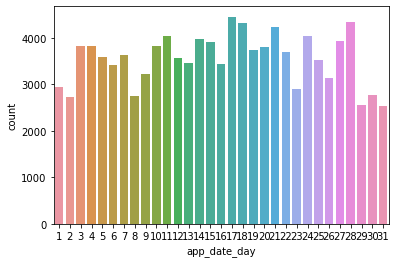

In [8]:
sns.countplot(x = df.app_date_day)
plt.show()

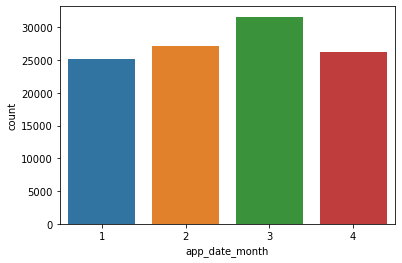

In [9]:
sns.countplot(x = df.app_date_month)
plt.show()

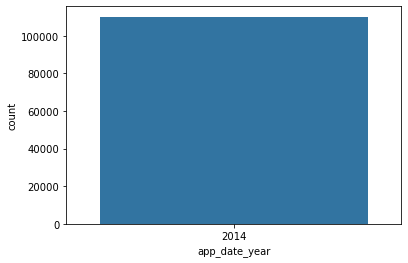

In [10]:
sns.countplot(x = df.app_date_year)
plt.show()

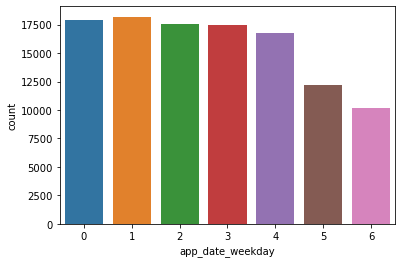

In [11]:
sns.countplot(x = df.app_date_weekday)
plt.show()

#### Легко видеть, что данные даны за 4 месяца 2014 года, тем самым не вижу особого смысле в годе, месяц пока что оставим
#### Так же можно добавить, была ли оставлена заявка на кредит в будние или выходные дни

In [12]:
df['app_date_weekend'] = df.app_date_weekday.apply(lambda x: 1 if x>= 5 else 0)

#### Удалим лишние признаки, оставшиеся же поделим между числовыми и бинарными

In [13]:
for i in ['app_date_year','app_date']:
    df = df.drop(i,axis = 1)
df_num.append('app_date_weekday')
df_num.append('app_date_month')
df_bin.append('app_date_weekend')
df_num.append('app_date_day')

#### 3. Education - уровень образования
##### Категориальный признак, в котором есть пустые значения, пока что просто избавимся от них и изменим название категорий на более удобные для нас значения
##### У нас есть 3 варианта избавления от пустых значений:удалить, поставить значение большего и поставить их в отдельную категорию.
##### Я решил оставить как можно больше данных и поставить их в отдельную категорию

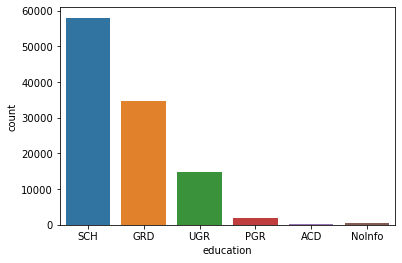

In [14]:
df['education'] = df['education'].fillna('NoInfo')
sns.countplot(x = df.education)
plt.show()

In [15]:
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df.education.value_counts()

4    57998
1    34768
5    14748
3     1865
2      478
0      291
Name: education, dtype: int64

In [16]:
df_cat.append('education')

#### 4. Sex - пол занимающего
##### Бинарный признак, пока что оставим его как он есть (бинарные признаки поменяем все одновременно) и посмотрим на значения

<AxesSubplot:xlabel='default', ylabel='count'>

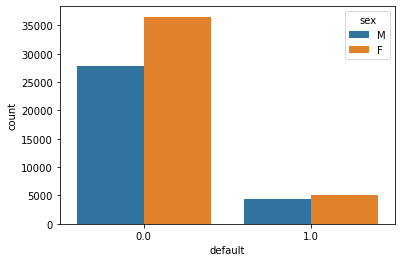

In [17]:
df_bin.append('sex')
sns.countplot(x= df['default'],hue = df['sex'])

##### Легко увидеть, что женщины немного более ответственные заемщики, так же что женщины в данной выборке занимают чаще чем мужчины. Пропусков так же нет.

#### 5. Age - возраст занимающего
##### Числовой признак, необходимо посмотреть выбросы и если они есть попробывать от них избавиться

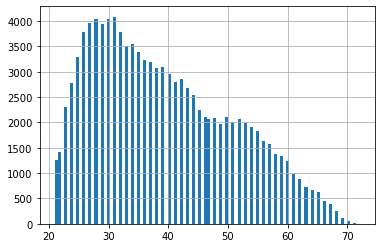

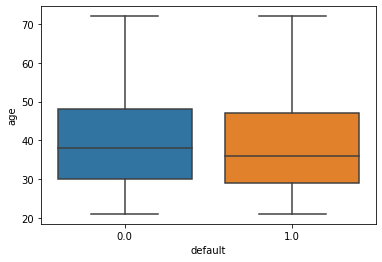

Всего выбросов: 0  Минимум: 3.0  Максимум: 75.0


(3.0, 75.0)

In [18]:
num_check('age')

##### Выбросов нет, так же можно увидеть, что в среднем, люди старше более ответственные заемщики добавим признак в числовые и пойдем дальше

In [19]:
df_num.append('age')

#### 6. car - наличие автомобиля
#### 7. car_type - является ли автомобиль иномаркой
##### Оба признака бинарные, оба без пропусков, посмотрим распределение

<AxesSubplot:xlabel='default', ylabel='count'>

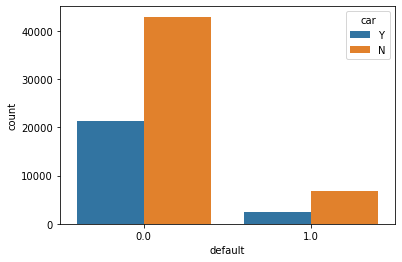

In [20]:
df_bin.append('car')
sns.countplot(x= df['default'],hue = df['car'])

<AxesSubplot:xlabel='default', ylabel='count'>

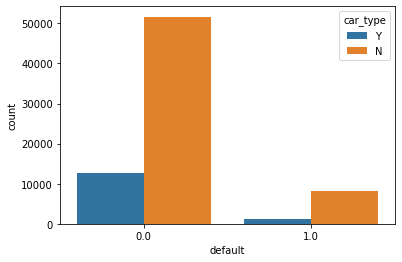

In [21]:
df_bin.append('car_type')
sns.countplot(x= df['default'],hue = df['car_type'])

##### Легко видеть, что клиенты с машиной реже допускают дефолт, клиенты с иномаркой же еще реже.

#### 8. decline_app_cnt - количество отказанных прошлых заявок

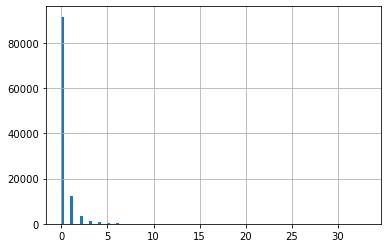

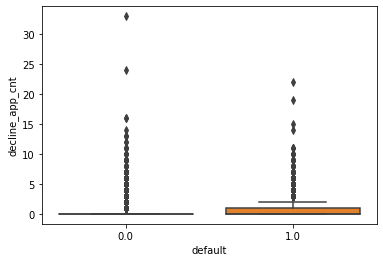

Всего выбросов: 18677  Минимум: 0.0  Максимум: 0.0


(0.0, 0.0)

In [22]:
num_check('decline_app_cnt')

In [23]:
df.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [24]:
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

##### Из-за того, что подавляющее большинство клиентов не получало отказ, все больше нуля считается выбросом, удалять выбросы в данном случае плохая идея, так как мы потеряем много данных, лучшим решением мне кажется поделить кол-во отказов на группы: 0 отказов, 1 отказ и 2 или более отказов.

In [25]:
def decline_app_cnt_to_cat(row):
    if row == 1:
        return 1
    else:
        return 2
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: 0 if x == 0 else decline_app_cnt_to_cat(x))

In [26]:
df['decline_app_cnt'].value_counts()

0    91471
1    12500
2     6177
Name: decline_app_cnt, dtype: int64

In [27]:
df_cat.append('decline_app_cnt')

#### 9. good_work - флаг наличия “хорошей” работы
##### Бинарный признак, пропусков нет, посмотрим распределение

<AxesSubplot:xlabel='default', ylabel='count'>

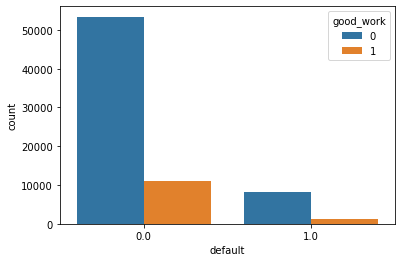

In [28]:
df_bin.append('good_work')
sns.countplot(x= df['default'],hue = df['good_work'])

In [29]:
df.groupby('good_work').default.value_counts(normalize = True)

good_work  default
0          0.0        0.866591
           1.0        0.133409
1          0.0        0.905498
           1.0        0.094502
Name: default, dtype: float64

##### Можно увидеть, что люди у которых значение good work равно 1, реже оказываются в ситуации дефолта

#### 10. score_bki - скоринговый балл по данным из БКИ
##### Числовой признак без пропусков

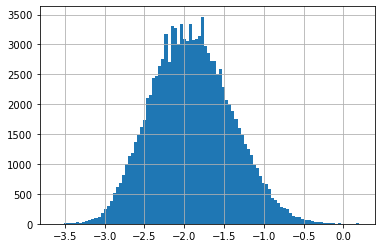

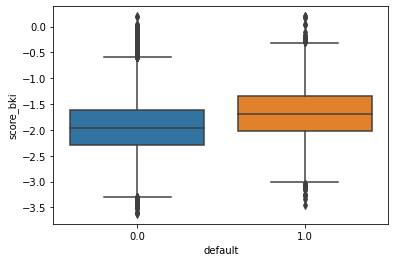

Всего выбросов: 518  Минимум: -3.299251946250001  Максимум: -0.5290698762499992


In [30]:
df_min,df_max = num_check('score_bki') 

##### Всего 518 выбросов, с числовыми значениями проще всего будет их удалить
###### Нам так же не стоит удалять ничего из df_test части, будем учитывать это

In [31]:
df = df[((df['score_bki'] <= df_max) & (df['score_bki'] >= df_min) & (df['default'].isna() == False)) | (df['default'].isna() == True)]

In [32]:
df_num.append('score_bki')

#### 11. bki_request_cnt - количество запросов в БКИ
##### Еще один числовой признак без пропусков, но с выбросами

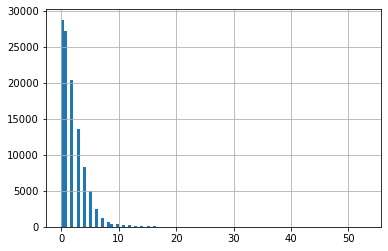

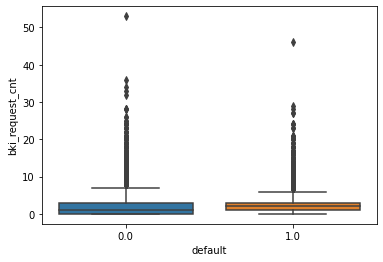

Всего выбросов: 2591  Минимум: -4.5  Максимум: 7.5


(-4.5, 7.5)

In [33]:
num_check('bki_request_cnt') 

##### Выбросов тут уже несколько больше, попробуем прологарифмировать

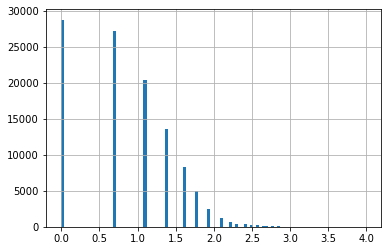

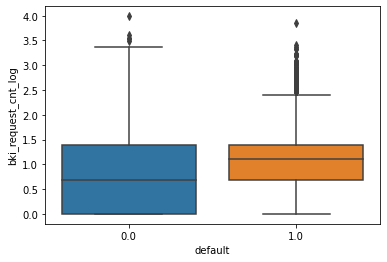

Всего выбросов: 12  Минимум: -2.0794415416798357  Максимум: 3.465735902799726


In [34]:
df['bki_request_cnt_log'] = np.log(df['bki_request_cnt'] + 1)
df_min, df_max = num_check('bki_request_cnt_log') 

##### После логарифмирования заметно улучшение, удалим оставшиеся выбросы и изначальный признак

In [35]:
df = df[((df['bki_request_cnt_log'] <= df_max) & (df['bki_request_cnt_log'] >= df_min) & (df['default'].isna() == False)) | (df['default'].isna() == True)]
df=df.drop('bki_request_cnt', axis = 1)

In [36]:
df_num.append('bki_request_cnt_log')

#### 12. region_rating - рейтинг региона
##### В теории числовой признак, но уникальных значений всего 7, да и не совсем понятно как этот рейтинг зачисляется и какая является ли разница между 60 и 70ю баллами, той же что и у 10 и 20 баллов. Рациональнее всего было бы поставить признак как категориальный.

<AxesSubplot:xlabel='default', ylabel='count'>

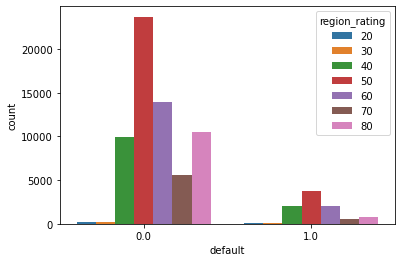

In [37]:
df_cat.append('region_rating')
sns.countplot(x= df['default'],hue = df['region_rating'])

In [38]:
df.groupby('region_rating').default.value_counts(normalize = True)
df['region_rating'] = df['region_rating'].apply(lambda x: 40 if x<=40 else x)

##### Легко видеть, что чем хуже район, тем выше шанс дефолта

#### 13. home_address - категоризатор домашнего адреса  
#### 14. work_address - категоризатор рабочего адреса
##### Оба признака категориальные с тремя значениями, без пропусков.

home_address  default
1             0.0        0.907685
              1.0        0.092315
2             0.0        0.845997
              1.0        0.154003
3             0.0        0.883480
              1.0        0.116520
Name: default, dtype: float64

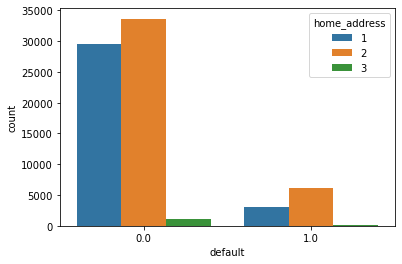

In [39]:
df_cat.append('home_address')
sns.countplot(x= df['default'],hue = df['home_address'])
df.groupby('home_address').default.value_counts(normalize = True)

work_address  default
1             0.0        0.926350
              1.0        0.073650
2             0.0        0.898140
              1.0        0.101860
3             0.0        0.853087
              1.0        0.146913
Name: default, dtype: float64

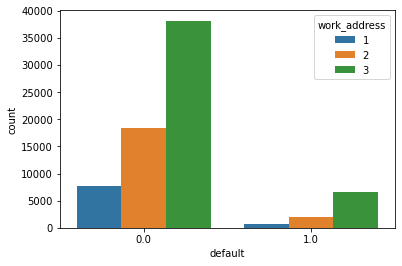

In [40]:
df_cat.append('work_address')
sns.countplot(x= df['default'],hue = df['work_address'])
df.groupby('work_address').default.value_counts(normalize = True)

##### Не совсем понятно, что признаки означают, третье значение рабочего адреса и второе значение домашнего адреса показывают лучшие результаты.

#### 15.income - доход заемщика
##### Очередной числовой признак с большим колличеством выбросов, без пропусков.

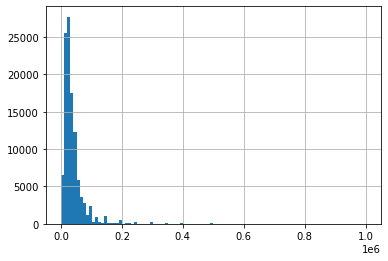

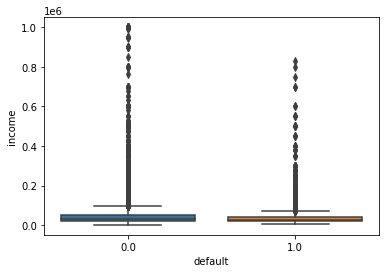

Всего выбросов: 6968  Минимум: -22000.0  Максимум: 90000.0


In [41]:
df_min, df_max = num_check('income') 

##### Выбросов очень много, вновь попробуем прологарифмировать

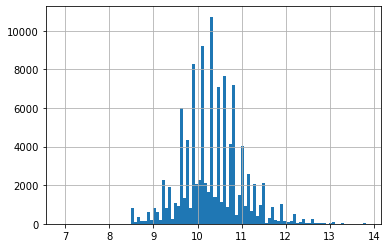

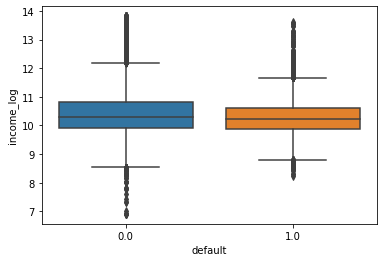

Всего выбросов: 2593  Минимум: 8.590378193705899  Максимум: 12.092136480586621


In [42]:
df['income_log'] = np.log(df['income'] + 1)
df_min,df_max = num_check('income_log')

##### Колличество выбросов, заметно уменьшилось, заменим признак его логарифмированной версией.

In [43]:
df = df.drop('income', axis = 1)
df_num.append('income_log')
df = df[((df['income_log'] <= df_max) & (df['income_log'] >= df_min) & (df['default'].isna() == False)) | (df['default'].isna() == True)]

#### 16.sna - связь заемщика с клиентами банка
#### 17.first_time - давность наличия информации о заемщике
##### Оба признака категориальные и имеют 4 категории, без пропусков.

sna  default
1    0.0        0.902021
     1.0        0.097979
2    0.0        0.850676
     1.0        0.149324
3    0.0        0.842655
     1.0        0.157345
4    0.0        0.789611
     1.0        0.210389
Name: default, dtype: float64

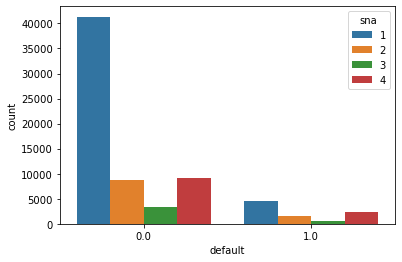

In [44]:
sns.countplot(x= df['default'],hue = df['sna'])
df.groupby('sna').default.value_counts(normalize = True)

first_time  default
1           0.0        0.814077
            1.0        0.185923
2           0.0        0.844466
            1.0        0.155534
3           0.0        0.880198
            1.0        0.119802
4           0.0        0.918790
            1.0        0.081210
Name: default, dtype: float64

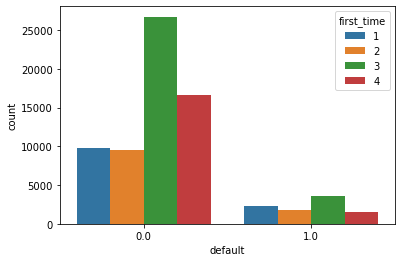

In [45]:
sns.countplot(x= df['default'],hue = df['first_time'])
df.groupby('first_time').default.value_counts(normalize = True)

In [46]:
df_cat.append('sna')
df_cat.append('first_time')

##### В sna, чем "выше" категория тем выше шанс дефолта. В first_time наоборот, чем "выше" категория тем меньше шанс. 

#### 18. foreign_passport - наличие загранпаспорта
##### Бинарный признак без пропусков

In [47]:
df_bin.append('foreign_passport')

#### Пройдясь по всем признакам имеем следующее

In [48]:
df.head(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,region_rating,...,sna,first_time,foreign_passport,default,app_date_day,app_date_month,app_date_weekday,app_date_weekend,bki_request_cnt_log,income_log
0,25905,4,M,62,Y,Y,0,0,-2.008753,50,...,4,1,N,0.0,1,2,5,1,0.693147,9.798183
1,63161,4,F,59,N,N,0,0,-1.532276,50,...,4,1,N,0.0,12,3,2,0,1.386294,9.852247
2,25887,4,M,25,Y,N,2,0,-1.408142,80,...,1,4,Y,0.0,1,2,5,1,0.693147,10.308986
3,16222,4,F,53,N,N,0,0,-2.057471,50,...,1,3,N,0.0,23,1,3,0,1.098612,9.210440
4,101655,1,M,48,N,N,0,1,-1.244723,60,...,1,4,Y,0.0,18,4,4,0,0.693147,10.308986


In [49]:
print(df_num,df_cat,df_bin, sep = '\n')

['app_date_weekday', 'app_date_month', 'app_date_day', 'age', 'score_bki', 'bki_request_cnt_log', 'income_log']
['education', 'decline_app_cnt', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
['app_date_weekend', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport']


### Теперь пройдемся по типам признаков
#### 1.Числовые признаки

<AxesSubplot:>

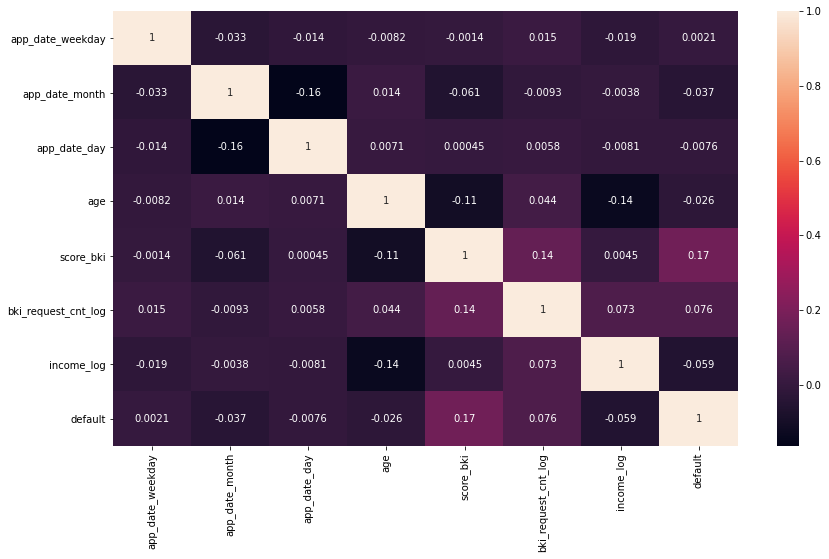

In [50]:
plt.figure(figsize=(14,8))
sns.heatmap(df[df_num+['default']].corr(), annot=True)

##### Сильной корреляции не между признаками не обнаружено
##### Посмотрим значимость

<AxesSubplot:>

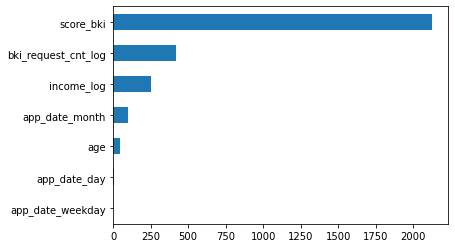

In [51]:
imp_num = pd.Series(f_classif(df[df['default'].isna() == False][df_num], df[df['default'].isna() == False]['default'])[0], index = df_num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

##### Легко видеть, что с большим отрывом score_bki опережает остальных в значимости

#### 2.Бинарные признаки
##### Заранее уже подправили единственный пробемный категориальный признак, сразу можно смотреть значимость

In [52]:
for column in df_bin:
    df[column] = label_encoder.fit_transform(df[column])

<AxesSubplot:>

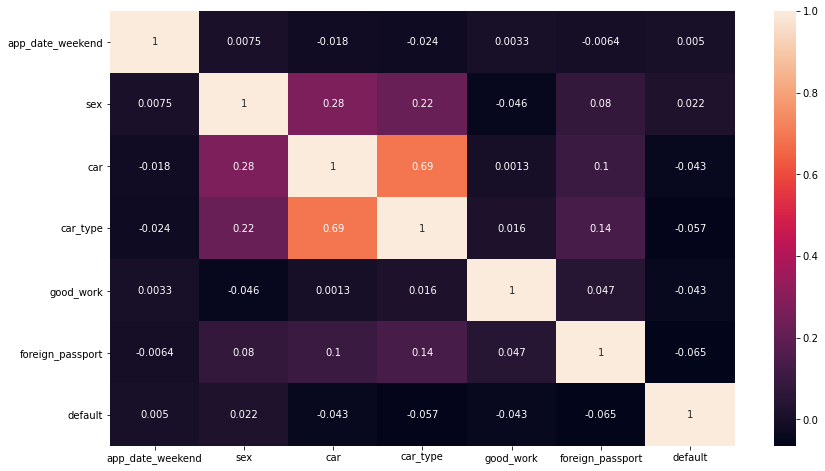

In [53]:
plt.figure(figsize=(14,8))
sns.heatmap(df[df_bin+['default']].corr(), annot=True)

##### Высока корреляция между машиной и типом машины, что не удивительно, у людей без машины (car = 0) всегда 0 в car_type. Все же думаю стоит их оставить, хотя как вариант можно было бы сделать из двух бинарных одну категориальную, (0=нет машины, 1 = обычная машина, 2 = иномарка)
##### Посмотрим значимость

<AxesSubplot:>

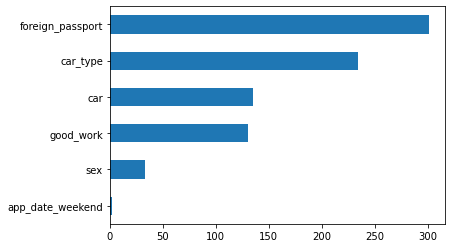

In [54]:
imp_bin = pd.Series(f_classif(df[df['default'].isna() == False][df_bin], df[df['default'].isna() == False]['default'])[0], index = df_bin)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

##### Самыми значимыми являются паспорт и является ли машина иномаркой

#### 3. Категориальные признаки
##### Единственный "проблемный" признак мы исправили заранее, посмотрим значимые

<AxesSubplot:>

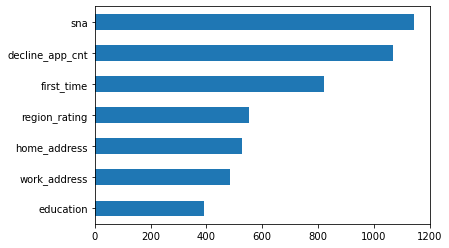

In [55]:
imp_cat = pd.Series(f_classif(df[df['default'].isna() == False][df_cat], df[df['default'].isna() == False]['default'])[0], index = df_cat)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

##### Самыми значимыми являются sna и decline_app_cnt

#### Создадим фиктивные переменные для категориальных признаков и стандартизируем числовые переменные

In [56]:
df = pd.get_dummies(df, columns = df_cat)

In [57]:
scaler = MinMaxScaler()
d = scaler.fit_transform(df[df_num])
df[df_num] = pd.DataFrame(d, columns=df_num)
df[df_num]

,app_date_weekday,app_date_month,app_date_day,age,score_bki,bki_request_cnt_log,income_log
0,0.833333,0.333333,0.000000,0.803922,0.416008,0.179052,0.418348
1,0.333333,0.666667,0.366667,0.745098,0.542629,0.358104,0.426176
2,0.833333,0.333333,0.000000,0.078431,0.575616,0.179052,0.492305
3,0.500000,0.000000,0.733333,0.627451,0.403061,0.283791,0.333251
4,0.666667,1.000000,0.566667,0.529412,0.619044,0.179052,0.492305
...,...,...,...,...,...,...,...
36344,0.000000,0.666667,0.533333,0.529412,0.607143,0.462843,0.492305
36345,0.833333,0.333333,0.000000,0.019608,0.199700,0.179052,0.447401
36346,0.000000,0.666667,0.533333,0.470588,0.588491,0.000000,0.492305
36347,0.500000,0.666667,0.633333,0.607843,0.364388,0.283791,0.492305


##### Обратно разделим датасет на train и test

In [58]:
df_train = df[df['default'].isna() == False]
df_test = df[df['default'].isna() == True]
df_test = df_test.drop('default', axis = 1)

# Обучение модели
##### Начнем обучение модели постепенно добавляя, что то новое

#### 1.Начальное обучение
##### Делим данные еще раз для валидации

In [59]:
X = df_train.drop(['client_id','default'], axis=1).values
Y = df_train['default'].values
X_train,X_valid,Y_train,Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

In [60]:
first_model = LogisticRegression(solver = 'liblinear')
first_model.fit(X_train, Y_train)
y_predict = first_model.predict(X_valid)
y_proba = first_model.predict_proba(X_valid)[:,1]

accuracy: 
0.875322501917579
f1: 
0.006666666666666666
Roc score:
0.6820129546720077
Confusion matrix:
[[12547     5]
 [ 1783     6]]


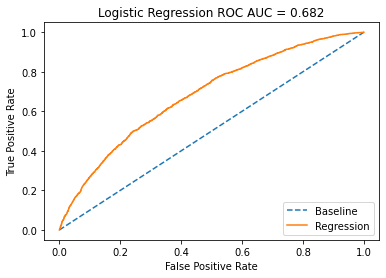

In [61]:
metrics_counter(Y_valid,y_predict,y_proba)

<AxesSubplot:xlabel='default', ylabel='count'>

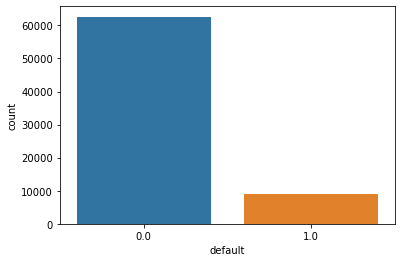

In [62]:
sns.countplot(x= df['default'])

##### Из-за большой разницы в колличестве, между 0 и 1 дефолта, модель намного чаще предсказывает 0, что не верно и стоит исправить при помощи underfitting
#### 2. Модель с underfitting

In [63]:
head_for_temp1 = df_train[df_train['default'] == 1].default.count()
temp1=df_train[df_train['default'] == 1]
temp2=df_train[df_train['default'] == 0]
temp2 = temp2.head(head_for_temp1)
balanced_train_df = pd.concat([temp1, temp2])
balanced_train_df = balanced_train_df.sort_index()

In [64]:
X = balanced_train_df.drop(['client_id','default'], axis=1).values
Y = balanced_train_df['default'].values
X_train,X_valid,Y_train,Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
balanced_model = LogisticRegression(solver = 'liblinear')
balanced_model.fit(X_train, Y_train)
y_predict = balanced_model.predict(X_valid)
y_proba = balanced_model.predict_proba(X_valid)[:,1]

accuracy: 
0.6350385038503851
f1: 
0.6290187307799833
Roc score:
0.6925094449287996
Confusion matrix:
[[1184  676]
 [ 651 1125]]


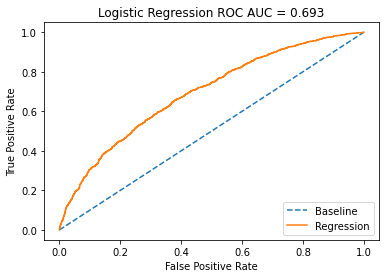

In [65]:
metrics_counter(Y_valid,y_predict,y_proba)

#### Модель стала очевидно, куда более точно предсказывать TN, хотя и увеличилось кол-во неудач с FP, но так или иначе модель явно стала точнее.
#### Теперь поищем гиперпараметры


model = LogisticRegression()

iter_ = 100
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, Y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

accuracy: 
0.6350385038503851
f1: 
0.6290187307799833
Roc score:
0.6924540467887241
Confusion matrix:
[[1184  676]
 [ 651 1125]]


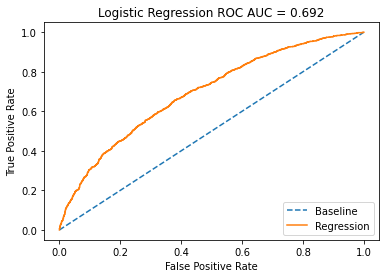

In [66]:
model_finish = LogisticRegression(C=1,class_weight = None, dual = False, fit_intercept = True, intercept_scaling =  1, l1_ratio = None,
                                  max_iter = 1000, multi_class = 'auto', n_jobs = None, penalty = 'none',random_state = None,
                                  solver = 'newton-cg',tol = 0.001,verbose = 0, warm_start = False)
model_finish.fit(X_train, Y_train)

y_predict = model_finish.predict(X_valid)
y_proba = model_finish.predict_proba(X_valid)[:,1]

metrics_counter(Y_valid,y_predict,y_proba)


In [67]:
print(classification_report(Y_valid,y_predict))

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64      1860
         1.0       0.62      0.63      0.63      1776

    accuracy                           0.64      3636
   macro avg       0.63      0.64      0.63      3636
weighted avg       0.64      0.64      0.64      3636



##### Итоги,сильно улучшить модель мы смогли лишь при помощи underfitting, в основном модель не менялась
##### Как еще можно улучшить модель?
##### Попытаться найти лучшие гиперпараметры и добавить/преобразить признаки.

### Submisson

In [68]:
tr_cut = 0.588
X_test = df_test.drop(['client_id'], axis=1).values
y_proba = model_finish.predict_proba(X_test)[:,1]
df_test['default'] = y_proba
df_test['default'] = df_test['default'].apply(lambda x: 1 if x >= tr_cut else 0)
submission = df_test[['client_id','default']]
submission.to_csv('submission.csv', index=False)

In [69]:
submission

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
...,...,...
36344,83775,1
36345,106254,0
36346,81852,1
36347,1971,0
